In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cargar y Analizar CSV (Base de datos)

In [2]:
df = pd.read_csv("train_database.csv")

In [3]:
df.isnull().sum()

ID          0
Subject     0
Name       10
Email      14
Message     0
Label       0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       132 non-null    object 
 1   Subject  132 non-null    object 
 2   Name     122 non-null    object 
 3   Email    118 non-null    object 
 4   Message  132 non-null    object 
 5   Label    132 non-null    float64
dtypes: float64(1), object(5)
memory usage: 6.3+ KB


## Limpiar lista de datos

In [5]:
#Definir funcion para limpiar bolsa de palabras de nombres o numeros
def limp_nom_num(register):
  del_words = ['[', ']', '(', ')', '*', '&', '{', '}', ':', ';', '.', ',', '','!', "'",'¡', '·', '\\', '-', '_', '#']
  clear_list = []
  for string in register:
    if string not in del_words:
      clear_list.append(string)

  #Recreate words from the divided register
  new_word = ""
  new_bag_words = []
  for word in clear_list:
    if word != " ":
      new_word += word
    else:
      new_bag_words.append(new_word)
      new_word = ""

  #Eliminar registros en blanco e strings image
  while "" in new_bag_words:
    new_bag_words.remove("")
  while "image" in new_bag_words:
    new_bag_words.remove("image")

  for word in new_bag_words:
    new_bag_words[new_bag_words.index(word)] = word.lower()

  return new_bag_words



In [6]:
del_words = ['santiago', 'aviles', 'tibocha', 'cesar', 'maldonado', 'trujillo','1', '2', '3', '4', '5', '6', '7', '8', '9', '10','u200c', 'xad', 'Í', 'вҗң', 'si']
df['Message'] = df['Message'].str.replace(r'\b(?:{})\b'.format('|'.join(del_words)), '', regex=True)
#Union de la segmentación
df['Message'] = df['Message'].str.join('')

In [7]:
df['Message'] = df['Message'].apply(limp_nom_num)

## Crear Visualización de datos

In [8]:
from wordcloud import WordCloud

In [9]:
def create_string_register(register: list):
  new_list = []
  for content in register:
    result = ""
    for string in content:
      result += string + " "
    new_list.append(result.strip())
  return new_list

In [10]:
#Agrupar datos en un nuevo dataframe
grouped_data = df.groupby("Label")
text_data_1 = create_string_register(grouped_data.get_group(1)["Message"].tolist())
text_data_0 = create_string_register(grouped_data.get_group(0)["Message"].tolist())

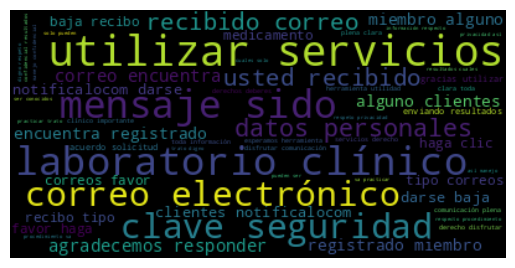

In [11]:
wordcloud = WordCloud().generate(" ".join(text_data_1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

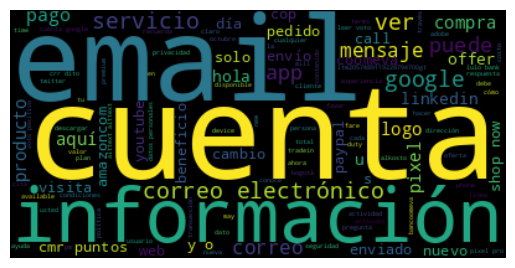

In [12]:
wordcloud = WordCloud().generate(" ".join(text_data_0))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Naive Bayes con Estrategia Bag of Words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [14]:
cv = CountVectorizer(max_features=300) #Encontrar y considerar las 500 palabras mas frecuentes
X = cv.fit_transform(df['Message'].apply(lambda x: ' '.join(x))).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, df['Label'], test_size=0.2, random_state=42)

In [15]:
#Tamaños y forma de los datos de entrada y testeo del modelo
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (105, 300)
X_test:  (27, 300)
y_train:  (105,)
y_test:  (27,)


In [16]:
#Modelo de Naive Bayes
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)

MultinomialNB()

## Metricas del modelo NB

In [17]:
#Precisión estandar
y_pred = model_NB.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8518518518518519

Este tipo de precisión es obtenida a partir de un ratio sencillo entre los objetos correctamente seleccionados entre el total de objetos.

Es util saberlo, sin embargo tiene ciertas falencias en decirnos el rendimiento del modelo, ya que si el dataset es inconsistente entonces este modelo lo sera:

"Suppose that our dataset had 99% real emails and 1% spam and that we built a classifier that predicted that all emails were real. Then, this algorithm would be 99% accurate, but horrible at classifying spam!"


In [18]:
#Matriz de Confusion

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[12  3]
 [ 1 11]]


|                           | Predicted: No Real Medical Email | Predicted: Real Medical Email |
|---------------------------|----------------------------------|-------------------------------|
| Actual: No Medical Emails | TN (True Negatives)              | FP (False Positives)          |
| Actual: Medical Emails    | FN (False Negatives)             | TP (True Positives)           |

|                           | Predicted: No Real Medical Email | Predicted: Real Medical Email |
|---------------------------|----------------------------------|-------------------------------|
| Actual: No Medical Emails | 11              | 4         |
| Actual: Medical Emails    | 1    | 11        |

Lo que se puede ver en la matriz de confusión es que de los 27 datos de pruebas, lo cierto es que hubo un fallo en prediccion en 5 datos, especificamente un Falso Negativo (FN) y 4 Falsos Positivos (FP).

Existen 22 datos de los 27 que se predicen correctamente

In [19]:
#F1 - Score
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86        15
         1.0       0.79      0.92      0.85        12

    accuracy                           0.85        27
   macro avg       0.85      0.86      0.85        27
weighted avg       0.86      0.85      0.85        27





* __Precisión__: Responde a la pregunta: Cuando se predice un valor positivo, que tan frecuente es que este sea correcto. Se obtiene a partir de la siguiente ecuación


> $Precision = \frac{TP}{TP + FP}$


* __Recall__: Responde a la pregunta: Cuando de hecho es un resultado positivo, que tan frecuentemente lo predice. Se obtiene a partir de la siguiente ecuacion:


> $Recall = \frac{TP}{TP + FN}$

* __f1-score__: Es una media harmonica entre el recall y la precisión. Es util si se quiere ver un indicador que priorice ambas cosas, que el modelo predica que el valor sea correcto, y que esete no sea un falso positivo. Se obtiene a partir de la siguiente ecuación:



> $f1-score = 2(\frac{precision \cdot recall}{precision + recall})$








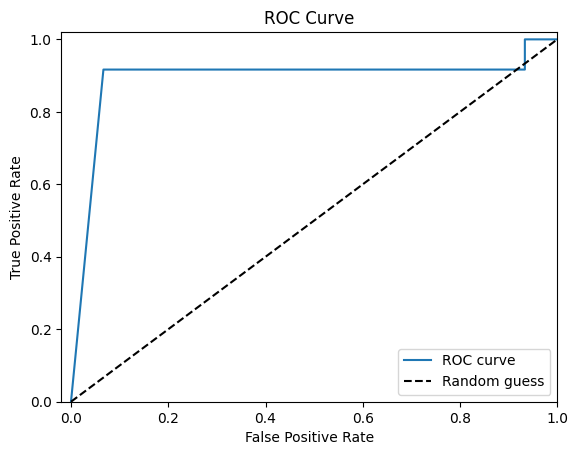

In [20]:
#ROC Curve (Reciver Operating Curve)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_prob = model_NB.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

# save figure
plt.savefig('Metrics/Naive_Bayes/roc_curve_NB.png', dpi=200)


*   __True Positive Rate (TPR o Sensibilidad)__: Es lo mismo que el recall, responde a la pregunta: Cuando de hecho es un resultado positivo, que tan frecuentemente lo predice. Se obtiene a partir de la siguiente ecuacion:

> $TPR(Recall) = \frac{TP}{TP + FN}$

*   __False Positive Rate (FPR o 1- Especificidad)__: Responde a la pregunta: Cuando de hecho es un negativo, que tan frecuentemente lo predice incorrectamente. Se obtiene a partir de la siguiente ecuación:

> $FPR = \frac{FP}{FP+TN}$



#### Lectura de la Grafica ROC

Cada uno de los puntos presentes en la grafica representan una configuración del tope o threshold que se uso para calcular los valores del TPR y FPR.

*   En el vertice o punto (0,0) se tiene una configuración de tope en 1. Eso implica que para que un email sea clasificado como medico debe exeder el 1, algo imposible, por lo cual ningun examen es medico. Eso implica que no existen ni falsos positivos (FP) ni verdaderos positivos (TP o VP), por ende tanto el TPR como el FPR dan 0.

*   El punto (1,1) se consigue con una configuración de tope 0. Eso implica que todo email es medico, lo cual genera un valor de 1 en el TPR y en el FPR, debido a que no existe valor pata Falsos Negativos (FN) ni Verdaderos negativos (VN o TN).

*  El resto de puntos son valores fluctuantes de configuración de threshold, el objetivo es encontrar un balance en el cual el TPR sea alto y el FPR sea lo mas bajo posible.




In [21]:
#Get AUC score (Area bajo la curva ROC)
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_prob)

0.8916666666666666

El indicador AUC se refiere al area bajo la curva ROC, este se interpreta principalmenente bajo los siguientes estandares:



*   Si el indicador esta cerca o es 0.5, el clasificador es lo mismo que adivinar, por lo cual el modelo es malo
*   Si el indicador esta cerca o es 0, el clasificador es inverso, implicando que esta clasificando las clases al reves
* Si el indicador esta cerca o es 1, el clasificador es bueno minimizando Falsos Negativos y Verdaderos Negativos



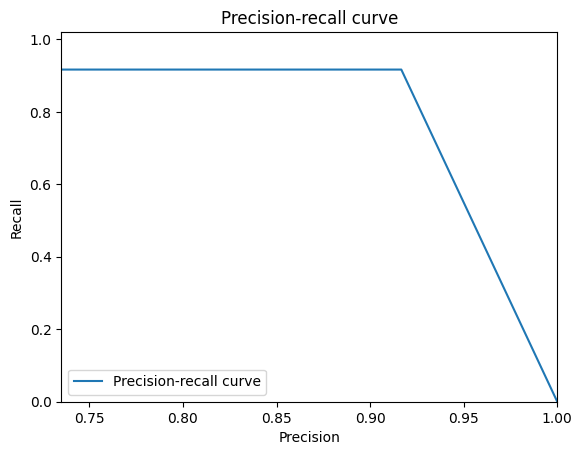

In [22]:
#Curva de precisión
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.xlim([0.735, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower left")

# save figure
plt.savefig('Metrics/Naive_Bayes/precision_recall_NB.png', dpi=200)

* __Precisión__: Responde a la pregunta: Cuando se predice un valor positivo, que tan frecuente es que este sea correcto. Se obtiene a partir de la siguiente ecuación


> $Precision = \frac{TP}{TP + FP}$


* __Recall__: Responde a la pregunta: Cuando de hecho es un resultado positivo, que tan frecuentemente lo predice. Se obtiene a partir de la siguiente ecuacion:


> $Recall = \frac{TP}{TP + FN}$

La grafica tiene como proposito exponer el trade-off que existe entre el recall y la precisión, ya que un valor de recall muy alto, como 1, no siempre es bueno, ya que incurriria a muchos falsos positivos.

En esta grafica el objetivo es que exista un buen valor de recall al igual que de precisión, por ende entre mas cerca este la linea de la parte superior izquierda mejor.

In [23]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred_prob) #precision promedio

0.8787393162393161

## Limpiar Subject para red neuronal

In [24]:
#Definir función para limpiar el subject
def limpiar_subject(registro):
  no_char = [":",";", ",", "{","}", "!", "¡"]
  no_words = ["mafe", "cesar", "maldonado", "santiago", "aviles", '🤩\U0001faf0🏻en', 're', '-', "harry", "esteban","sanchez", "guevara", "1000706784" ]
  #Limpiar caracter por caracter
  list_words = registro.split()
  new_list_words = []
  for word in list_words:
    word = word.lower()
    new_word = []
    for letter in word:
      if letter not in no_char:
        new_word.append(letter)
    word = "".join(new_word)
    new_list_words.append(word)

  #Limpiar por palabra
  new_subject = []
  for word in new_list_words:
    if word not in no_words:
      new_subject.append(word)

  ret_subject = " ".join(new_subject)

  return ret_subject


In [25]:
df['Subject'] = df["Subject"].apply(limpiar_subject)

In [26]:
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
#Funcion para limpiar stopwords de una string
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('spanish'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)

2023-11-09 00:09:39.800270: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 00:09:39.808247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 00:09:39.857131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 00:09:39.857169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 00:09:39.857203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [27]:
df['Subject'] = df["Subject"].apply(remove_stop_words)

## Red Neuronal NN

### Tokenizar y Estandarizar Strings para usarlas como Input

In [28]:
def get_Max(sequence):
  max_lenght = 0
  for l in sequence:
    if max_lenght < len(l):
      max_lenght = len(l)
  return max_lenght

def get_Min(sequence):
  min_lenght = 1000000000000
  for l in sequence:
    if min_lenght > len(l):
      min_lenght = len(l)
  return min_lenght

In [29]:
from keras.preprocessing.text import Tokenizer

#Tokenizar cada una de las columnas para convertirlas en un numero
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Subject'])
sequences_subject = tokenizer.texts_to_sequences(df['Subject'])
tokenizer.fit_on_texts(df['Message'])
sequences_message = tokenizer.texts_to_sequences(df['Message'])


In [30]:
#Encontrar tamaños para no perder tanta información
print("Estado de datos despues de la tokenización")
max_subject = get_Max(sequences_subject)
min_subject = get_Min(sequences_subject)
average_subject = int((max_subject + min_subject) / 2)
print(f"Maximo: {max_subject}, Minimo: {min_subject}, Promedio: {average_subject}")

max_message = get_Max(sequences_message)
min_message = get_Min(sequences_message)
average_message = int((max_message + min_message) / 2)
print(f"Maximo: {max_message}, Minimo: {min_message}, Promedio: {average_message}")

Estado de datos despues de la tokenización
Maximo: 19, Minimo: 1, Promedio: 10
Maximo: 1104, Minimo: 0, Promedio: 552


In [31]:
#Estandarizar el tamaño de las listas
from keras.preprocessing.sequence import pad_sequences

padded_subject = pad_sequences(sequences_subject, maxlen=10) #Se estandariza a un maximo de 9
padded_subject

array([[  0,   0,   0, ...,   0,   0,  78],
       [  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   1,   2],
       ...,
       [  0,   0,   0, ..., 355, 356, 357],
       [  0,   0, 358, ..., 363, 364, 365],
       [ 64,  29, 367, ...,  28, 370, 371]], dtype=int32)

In [32]:
padded_message = pad_sequences(sequences_message, maxlen=50) #Se estandariza a un maximo de 50
padded_message

array([[ 241, 1617,  552, ...,  296,   42,  412],
       [ 154,  125,   48, ...,    9,   96,   39],
       [ 154,  125,   48, ...,    9,   96,   39],
       ...,
       [  21,  295,  945, ...,  432,  166,   40],
       [ 322,  323,  324, ...,  355,  583, 1008],
       [5111,  524,   52, ...,  160, 5117, 1528]], dtype=int32)

In [33]:
#Crear Dataframe para sintetizar todos los resultados
df_NN = pd.DataFrame({'Subject': padded_subject.tolist(), 'Message': padded_message.tolist(), 'Label': df['Label']})

In [34]:
# Define input variables (features) and output variable (labels)
X = df_NN[['Subject', 'Message']]  # Input variables
y = df_NN['Label']  # Output variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from keras.models import Model
from keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Concatenate
from keras.layers import Dropout

subject_input = Input(shape=(None,), dtype='int32', name='subject') #Input de Subject
message_input = Input(shape=(None,), dtype='int32', name='message') #Input del Mensaje

# Embedding layers
subject_emb = Embedding(input_dim=6000, output_dim=64)(subject_input) # assuming a vocabulary size of 6000
message_emb = Embedding(input_dim=6000, output_dim=64)(message_input) # assuming a vocabulary size of 6000

subject_emb = Dropout(0.5)(subject_emb)
message_emb = Dropout(0.5)(message_emb)


# GlobalAveragePooling1D layers
subject_pool = GlobalAveragePooling1D()(subject_emb)
message_pool = GlobalAveragePooling1D()(message_emb)

# Concatenate layer
concat = Concatenate()([subject_pool, message_pool])

concat = Dropout(0.5)(concat)

# Dense layers
dense = Dense(10, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)


model = Model(inputs=[subject_input, message_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Model Summary
model.summary()

2023-11-09 00:09:43.574184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 00:09:43.575418: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 subject (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 message (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 64)             384000    ['subject[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 64)             384000    ['message[0][0]']             
                                                                                              

In [36]:
#Arquitectura del modelo
from keras.utils import plot_model

plot_model(model, to_file='Metrics/Neuronal Network/NN_Architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.




*   __Primer Nivel (Subject, Message)__: La capa de primer nivel, crea dos neuronas, las cuales sirven como inputs para el modelo. Estas no reciben un tamaño especifico y el output es el mismo que el input,ya que su proposito es recibir la informacíon

*   __Segundo Nivel(Embedding)__: Esta capa, la cual existe una por cada input, existe con el proposito de convertir los inputs 'int32' en vectores densos de tamaño 64, dado que el tamaño del vocabulario es 6000 (Proceso parecido al one-hot-ecoding) https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce


* __Tercer Nivel(Pooling 1D)__: Esta capa reduce la dimensionalidad de los outputs de la capa anterior, esto lo hace a traves de un mapeo y tiene el fin de reducir el sobreajuste a los datos

* __Cuarto Nivel(Concatenar)__: Esta capa esta encargada de conectar o concatenar los dos procesos que vienen separados en un solo output para el tratamiento tradicional de una red neuronal

* __Quinto Nivel(Capa Densa)__: Esta es una red de nodos completamente conectados (Red Densa), El 10 es el numero de outputs, el cual se puede variar para experiemntar como diferentes pesos afectan al resultado. Usa una funci`ón de activación RELU -> El output es positivo de lo contrario es 0

* __Sexto y Ultimo Nivel(Output)__: La capa final solo tiene un nodo, ya que este problema de clasificación binaria. Usa una función Sigmoid que basicamente retorna una probabilidad


> 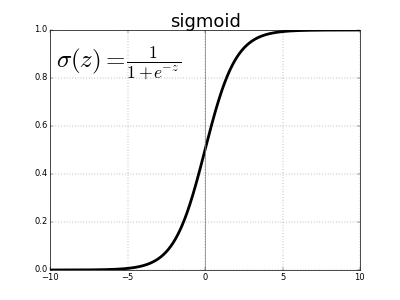



In [37]:
X_train['Subject'] = np.array(X_train['Subject'].tolist())
X_train['Message'] = np.array(X_train['Message'].tolist())
model.fit([X_train['Subject'], X_train['Message']], y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 2s 130ms/step - loss: 0.6973 - accuracy: 0.4643 - val_loss: 0.6886 - val_accuracy: 0.5714
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6900 - accuracy: 0.5238 - val_loss: 0.6834 - val_accuracy: 0.8095
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6879 - accuracy: 0.5000 - val_loss: 0.6790 - val_accuracy: 0.8571
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6869 - accuracy: 0.5833 - val_loss: 0.6748 - val_accuracy: 0.8095
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6798 - accuracy: 0.7143 - val_loss: 0.6708 - val_accuracy: 0.8095
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6770 - accuracy: 0.7024 - val_loss: 0.6663 - val_accuracy: 0.8095
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6751 - accuracy: 0.6905 - val_loss: 0.6617 - val_accuracy: 0.8571
Epoch 8/100
3/3 [==

In [38]:
X_test['Subject'] = np.array(X_test['Subject'].tolist())
X_test['Message'] = np.array(X_test['Message'].tolist())
predictions = model.predict([X_test['Subject'], X_test['Message']])

1/1 [==============================] - 0s 100ms/step


In [39]:
predictions_class = [1 if p > 0.5 else 0 for p in predictions]

## Metricas del Modelo NN

In [40]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_test, predictions_class)
precision = metrics.precision_score(y_test, predictions_class)
recall = metrics.recall_score(y_test, predictions_class)
f1 = metrics.f1_score(y_test, predictions_class)

metric = pd.DataFrame({"Acurracy": [accuracy], "Precision": [precision], "Recall": [recall], "F1-Score": [f1]})
metric

,Acurracy,Precision,Recall,F1-Score
0,0.851852,1.0,0.666667,0.8


In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        15
         1.0       1.00      0.67      0.80        12

    accuracy                           0.85        27
   macro avg       0.89      0.83      0.84        27
weighted avg       0.88      0.85      0.85        27



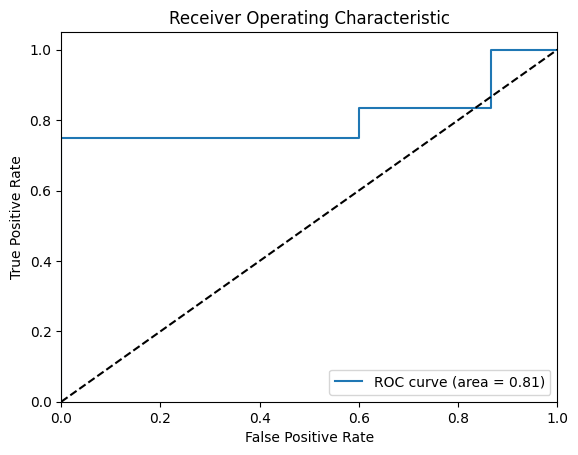

<Figure size 640x480 with 0 Axes>

In [42]:
# Compute ROC curve and ROC area
fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# save figure
plt.savefig('Metrics/Neuronal Network/roc_curve_NN.png', dpi=200)

### Exportar modelo de IA

In [43]:
from joblib import dump
dump(model_NB, 'Server/Models/model_NB.joblib')

['Models/model_NB.joblib']

In [44]:
import tensorflow as tf

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with tf.io.gfile.GFile('Server/Models/model_NN.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpsf2uosuq/assets


INFO:tensorflow:Assets written to: /tmp/tmpsf2uosuq/assets
2023-11-09 00:09:54.149380: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-09 00:09:54.149436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-09 00:09:54.151751: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsf2uosuq
2023-11-09 00:09:54.156527: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-09 00:09:54.156565: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsf2uosuq
2023-11-09 00:09:54.161632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-09 00:09:54.162603: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-09 00:09:54.229944: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [46]:
import pickle

vocab = cv.vocabulary_
params = cv.get_params()

with open('Server/Models/cv_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)
with open('Server/Models/cv_params.pkl', 'wb') as f:
    pickle.dump(params, f)